In [1]:
pip install surprise

     |████████████████████████████████| 11.8 MB 951 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619423 sha256=163586b1b1b92265002aef10352ef5f8cf3e65bcd6d41cb1c254e38a9a159758
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
from datetime import time, datetime
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import sparse
from scipy.sparse import csr_matrix
import random
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.pyplot import figure

In [3]:
import xgboost as xgb
from surprise import BaselineOnly, KNNBaseline, SVD, SVDpp
from surprise import Reader, Dataset

In [4]:
# 13 feature csv path
trainFeaturePath = "/content/drive/MyDrive/Netflix Movie recommendation/data/updated_train_data_frame.csv"
testFeaturePath = "/content/drive/MyDrive/Netflix Movie recommendation/data/test_data_frame.csv"
modelResultPath = "/content/drive/MyDrive/Netflix Movie recommendation/data/model_results.csv"

In [5]:
class Constant:
  rmse = 'rmse'
  mape = 'mape'
  predictions = 'predictions'

In [6]:
# Helper methods for XgBoost
def getErrorMetrics(yTrue, yPred):
  rmse = np.sqrt(np.mean((yTrue - yPred)**2))
  mape = np.mean(np.abs((yTrue- yPred)/yTrue)) * 100
  return rmse, mape


def runXgBoost(model, xTrain, yTrain, xTest, yTest):

  # Fit the model
  start = datetime.now()
  print("Fitting the model on Train data")
  model.fit(xTrain, yTrain, eval_metric="rmse")
  print("Trained the model. Time taken :", datetime.now()-start)

  # Evaluate the model on train data
  print("Evaluate the model on train data")
  yTrainPred = model.predict(xTrain)
  trainRMSE, trainMAPE = getErrorMetrics(yTrain.values, yTrainPred)

  trainResults = {
      Constant.rmse : trainRMSE,
      Constant.mape : trainMAPE,
      Constant.predictions : yTrainPred
  }

    # Evaluate the model on test data
  print("Evaluate the model on test data")
  yTestPred = model.predict(xTest)
  testRMSE, testMAPE = getErrorMetrics(yTest.values, yTestPred)

  testResults = {
      Constant.rmse : testRMSE,
      Constant.mape : testMAPE,
      Constant.predictions : yTestPred
  }

  return trainResults, testResults

In [7]:
# Helper methods for Surprise models
def getRatings(predictions):
  actual = np.array([pred.r_ui for pred in predictions])
  predicted = np.array([pred.est for pred in predictions])
  return actual, predicted


def runSurprise(model, trainData, testData):
  # Fit the model on train data
  print("Training the model...")
  start = datetime.now()
  model.fit(trainData)
  print(f"The time taken to train is {datetime.now()-start}")

  #Evaluating on trainData
  print("Evaluating the model on train data...")
  trainPredicted = model.test(trainData.build_testset())
  actual, predicted = getRatings(trainPredicted) 
  trainRMSE, trainMAPE = getErrorMetrics(actual, predicted)

  trainResults = {
      Constant.rmse : trainRMSE,
      Constant.mape : trainMAPE,
      Constant.predictions : predicted
  }

  #Evaluating on testData
  print("Evaluating the model on test data...")
  testPredicted = model.test(testData)
  actual, predicted = getRatings(testPredicted) 
  testRMSE, testMAPE = getErrorMetrics(actual, predicted)

  testResults = {
      Constant.rmse : testRMSE,
      Constant.mape : testMAPE,
      Constant.predictions : predicted
  }

  return trainResults, testResults

In [8]:
# Helper method to print
def printResults(results, isTrain=True): 
  message = "Train Results:" if isTrain else "Test Results:"
  print("**************************************************")
  print(message)
  print(Constant.rmse, results[Constant.rmse])
  print(Constant.mape, results[Constant.mape])
  print("**************************************************")

In [9]:
# Read the train data
trainData = pd.read_csv(trainFeaturePath, names = ['user', 'movie', 'globalAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'userAvg', 'movieAvg', 'rating'], header=None)

In [10]:
# Read the test data
testData = pd.read_csv(testFeaturePath, names = ['user', 'movie', 'globalAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'userAvg', 'movieAvg', 'rating'], header=None)

In [11]:
trainData.head()

,user,movie,globalAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,userAvg,movieAvg,rating
0,69809,2,3.570182,3.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,5.0,4.0,3.513619,4.000000,5
1,1315005,2,3.570182,3.0,5.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,3.634921,4.000000,4
2,1576540,2,3.570182,5.0,3.0,4.0,4.0,4.0,2.0,4.0,4.0,3.0,3.0,3.758794,4.000000,4
3,1666394,2,3.570182,5.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,5.0,3.945455,4.000000,3
4,46086,3,3.570182,4.0,4.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,5.0,3.805031,3.565217,4


In [12]:
trainData.shape

(110973, 16)

In [13]:
testData.head()

,user,movie,globalAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,userAvg,movieAvg,rating
0,99400,5,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,5
1,200805,5,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,5
2,334242,5,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,1
3,1096005,5,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,5
4,1141610,5,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,3.570182,5


In [14]:
testData.shape

(66502, 16)

In [15]:
# Initialize Train set
reader = Reader(rating_scale=(1,5))

trainDataSurprise  = Dataset.load_from_df(trainData[["user", "movie", "rating"]], reader)

trainSet = trainDataSurprise.build_full_trainset()

In [16]:
# Initialize test set
testSet = list(zip(testData.user.values, testData.movie.values, testData.rating.values))
print(testSet[:5])

[(99400, 5, 5), (200805, 5, 5), (334242, 5, 1), (1096005, 5, 5), (1141610, 5, 5)]


In [17]:
# Initialize Evaluation dictionary
modelEvalTrain = {}
modelEvalTest = {}

## XgBoost with 13 features

In [18]:
# Prepare the train data
xTrain = trainData.drop(['user', 'movie', 'rating'], axis=1)
yTrain = trainData.rating

In [19]:
# Prepare the test data
xTest = testData.drop(['user', 'movie', 'rating'], axis=1)
yTest = testData.rating

In [20]:
# Initialize the model
baseXgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)

In [21]:
# Evaluate 
trainResults, testResults = runXgBoost(baseXgb, xTrain, yTrain, xTest, yTest)

Fitting the model on Train data
[00:19:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Trained the model. Time taken : 0:00:05.590368
Evaluate the model on train data
Evaluate the model on test data


In [22]:
printResults(trainResults)
printResults(testResults, isTrain=False)

**************************************************
Train Results:
rmse 0.8667405033681259
mape 26.255473372223648
**************************************************
**************************************************
Test Results:
rmse 1.1006040592464112
mape 35.83009306603983
**************************************************


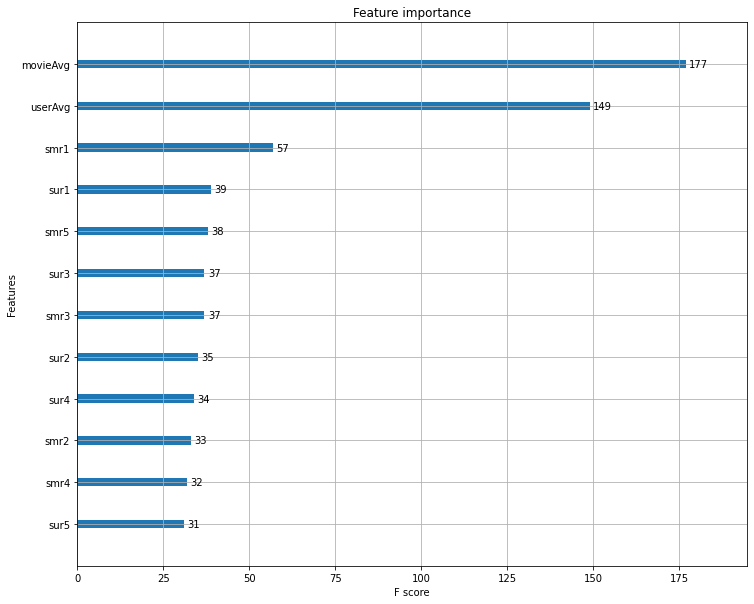

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(baseXgb, ax=ax)
plt.show()

In [24]:
modelEvalTrain["baseline_xgb"] = trainResults
modelEvalTest["baseline_xgb"] = testResults

## Surprise Baseline Model

In [25]:
# Options to train
baselineOptions = {"method": "sgd", "learning_rate": 0.001}

In [26]:
# Initialize model
baselineModel = BaselineOnly(bsl_options=baselineOptions)

In [27]:
# Evaluate the model
trainResults, testResults = runSurprise(baselineModel, trainSet, testSet)

Training the model...
Estimating biases using sgd...
The time taken to train is 0:00:01.004759
Evaluating the model on train data...
Evaluating the model on test data...


In [28]:
printResults(trainResults)
printResults(testResults, isTrain=False)

**************************************************
Train Results:
rmse 0.9649190798932278
mape 30.801422292191223
**************************************************
**************************************************
Test Results:
rmse 1.1154452059792708
mape 36.836370499540436
**************************************************


In [29]:
modelEvalTrain["suprise_baseline"] = trainResults
modelEvalTest["suprise_baseline"] = testResults

## Surprise KNN Baseline 

### KNN User

In [30]:
# Options to train
knnBaselineOptions = {"method": "sgd"}

In [31]:
# Similarity Options
userSimilarityOptions = {
    'user_based' : True,
    'name': 'pearson_baseline',
    'shrinkage': 100,
    'min_support': 1
}

In [32]:
# Initialize Knn user model with K=40
knnBaselineUser = KNNBaseline(k=90, sim_options = userSimilarityOptions, bsl_options = knnBaselineOptions)

In [33]:
# Evaluate the model
knnUTrainResults, knnUTestResults = runSurprise(knnBaselineUser, trainSet, testSet)

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
The time taken to train is 0:01:04.784397
Evaluating the model on train data...
Evaluating the model on test data...


In [34]:
printResults(knnUTrainResults)
printResults(knnUTestResults, isTrain=False)

**************************************************
Train Results:
rmse 0.3000887019922082
mape 8.214582159370707
**************************************************
**************************************************
Test Results:
rmse 1.1149804262819085
mape 36.8183863311759
**************************************************


In [35]:
modelEvalTrain['knn_baseline_user'] = knnUTrainResults 
modelEvalTest['knn_baseline_user'] = knnUTestResults

### KNN Movie

In [36]:
# Similarity Options
movieSimilarityOptions = {
    'user_based' : False,
    'name': 'pearson_baseline',
    'shrinkage': 100,
    'min_support': 1
}

In [37]:
# Initialize Knn user model with K=30
knnBaselineMovie = KNNBaseline(k=30, sim_options = movieSimilarityOptions, bsl_options = knnBaselineOptions)

In [38]:
# Evaluate the model
knnMTrainResults, knnMTestResults = runSurprise(knnBaselineMovie, trainSet, testSet)

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
The time taken to train is 0:00:01.063206
Evaluating the model on train data...
Evaluating the model on test data...


In [39]:
printResults(knnMTrainResults)
printResults(knnMTestResults, isTrain=False)

**************************************************
Train Results:
rmse 0.1839874204118524
mape 4.413034326100939
**************************************************
**************************************************
Test Results:
rmse 1.1151091099517698
mape 36.82177603139311
**************************************************


In [40]:
modelEvalTrain['knn_baseline_movie'] = knnMTrainResults 
modelEvalTest['knn_baseline_movie'] = knnMTestResults

## Matrix Factorization 

### SVD 

In [41]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True, n_epochs=81, lr_all=0.05)

In [42]:
# Evaluate the model
svdTrainResults, svdTestResults = runSurprise(svd, trainSet, testSet)

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processi

In [43]:
printResults(svdTrainResults)
printResults(svdTestResults, isTrain=False)

**************************************************
Train Results:
rmse 0.22110636394653016
mape 5.927804420296849
**************************************************
**************************************************
Test Results:
rmse 1.1144937014843392
mape 36.792656281700076
**************************************************


In [44]:
modelEvalTrain['svd'] = svdTrainResults 
modelEvalTest['svd'] = svdTestResults



### SVD++



In [45]:
# initiallize the model
svdPP = SVDpp(n_factors=50, random_state=15, verbose=True, n_epochs=41, lr_all=0.002)

In [46]:
# Evaluate the model
svdppTrainResults, svdppTestResults = runSurprise(svdPP, trainSet, testSet)

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
 processing epoch 20
 processing epoch 21
 processing epoch 22
 processing epoch 23
 processing epoch 24
 processing epoch 25
 processing epoch 26
 processing epoch 27
 processing epoch 28
 processing epoch 29
 processing epoch 30
 processing epoch 31
 processing epoch 32
 processing epoch 33
 processing epoch 34
 processing epoch 35
 processing epoch 36
 processing epoch 37
 processing epoch 38
 processing epoch 39
 processing epoch 40
The time taken to train is 0:01:48.368719
Evaluating the model on train data...
Evaluating the model on test data...


In [47]:
printResults(svdppTrainResults)
printResults(svdppTestResults, isTrain=False)

**************************************************
Train Results:
rmse 0.7439631536988129
mape 22.789077580289828
**************************************************
**************************************************
Test Results:
rmse 1.1149561411381645
mape 36.76554213934969
**************************************************


In [48]:
modelEvalTrain['svd_pp'] = svdppTrainResults 
modelEvalTest['svd_pp'] = svdppTestResults

### Final model XgBoost Regressor with 19 features 

In [49]:
# Append the results from baseline models to the train data frame
trainData["baseline_xgb"] = modelEvalTrain["baseline_xgb"][Constant.predictions]
trainData["suprise_baseline"] = modelEvalTrain["suprise_baseline"][Constant.predictions]
trainData["knn_baseline_user"] = modelEvalTrain["knn_baseline_user"][Constant.predictions]
trainData["knn_baseline_movie"] = modelEvalTrain["knn_baseline_movie"][Constant.predictions]
trainData["svd"] = modelEvalTrain["svd"][Constant.predictions]
trainData["svd_pp"] = modelEvalTrain["svd_pp"][Constant.predictions]

In [50]:
# Append the results from baseline models to the test data frame
testData["baseline_xgb"] = modelEvalTest["baseline_xgb"][Constant.predictions]
testData["suprise_baseline"] = modelEvalTest["suprise_baseline"][Constant.predictions]
testData["knn_baseline_user"] = modelEvalTest["knn_baseline_user"][Constant.predictions]
testData["knn_baseline_movie"] = modelEvalTest["knn_baseline_movie"][Constant.predictions]
testData["svd"] = modelEvalTest["svd"][Constant.predictions]
testData["svd_pp"] = modelEvalTest["svd_pp"][Constant.predictions]

In [51]:
print(all(trainData.columns == testData.columns))

True


In [52]:
# Train and test data for XgBoost Final model
xTrain = trainData.drop(['user', 'movie', 'rating'], axis=1)
yTrain = trainData['rating']

# Test data
xTest = testData.drop(['user', 'movie', 'rating'], axis=1)
yTest = testData['rating']

In [53]:
# Initialize the final model
xgbFinal = xgb.XGBRegressor(n_jobs=10, random_state=15)

In [54]:
# Evaluate the model
trainResults, testResults = runXgBoost(xgbFinal, xTrain, yTrain, xTest, yTest)

Fitting the model on Train data
[00:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Trained the model. Time taken : 0:00:09.486266
Evaluate the model on train data
Evaluate the model on test data


In [55]:
printResults(trainResults)
printResults(testResults, isTrain=False)

**************************************************
Train Results:
rmse 0.8613070669464155
mape 25.958369271039196
**************************************************
**************************************************
Test Results:
rmse 1.101782607994064
mape 35.88878016859034
**************************************************


In [56]:
# Store the final evaluations
modelEvalTrain['xgb_final'] = trainResults
modelEvalTest['xgb_final'] = testResults

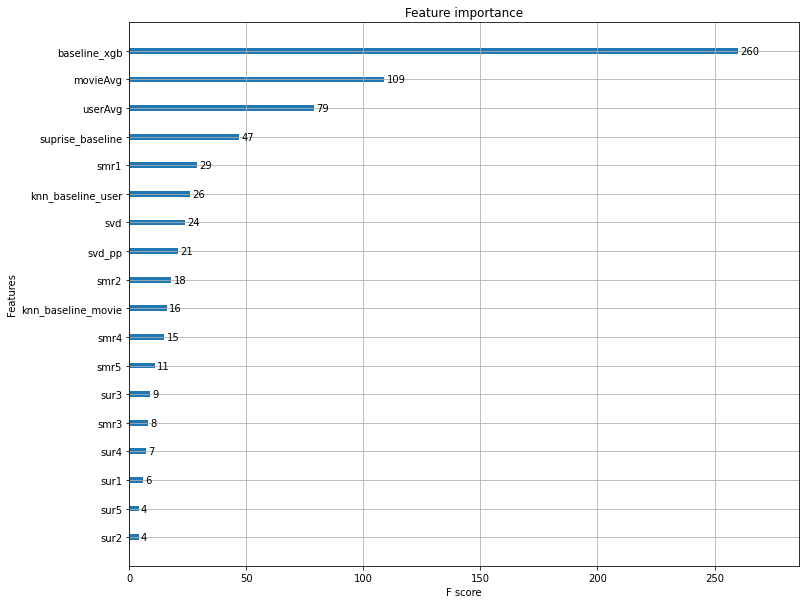

In [57]:
fig, ax = plt.subplots(figsize=(12, 10))
xgb.plot_importance(xgbFinal, ax=ax)
plt.show()

### Comparison of models

In [58]:
# Helper method
def plotFinalMetrics(xValues, yValues, title, yLabel):
  plt.figure(figsize=(12, 10))
  plt.plot(xValues, yValues)
  plt.xlabel("Model")
  plt.ylabel(yLabel)
  plt.title(title)
  plt.show()

In [59]:
# Plot graph for RMSE and MAPE scores on Test Data 
modelNames = list(modelEvalTest.keys())
rmseValues = [modelEvalTest[name][Constant.rmse] for name in modelNames]
mapeValues = [modelEvalTest[name][Constant.mape] for name in modelNames]

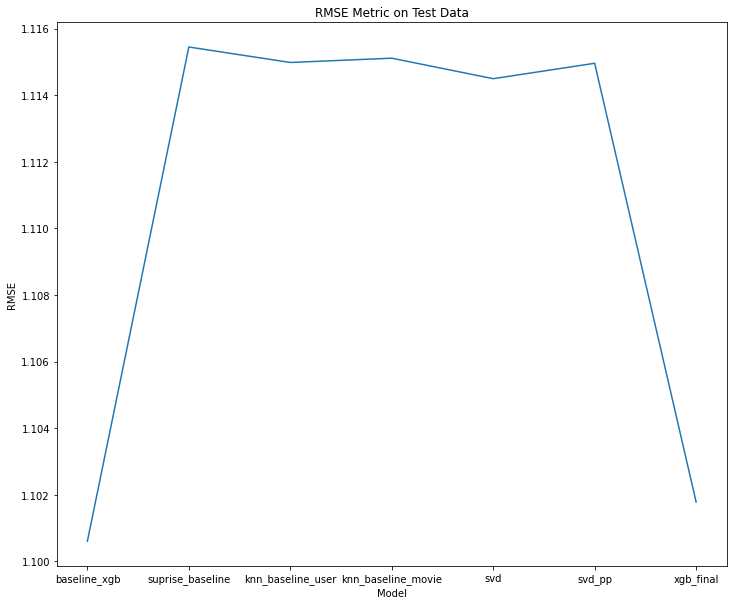

In [60]:
plotFinalMetrics(modelNames, rmseValues, "RMSE Metric on Test Data", Constant.rmse.upper())

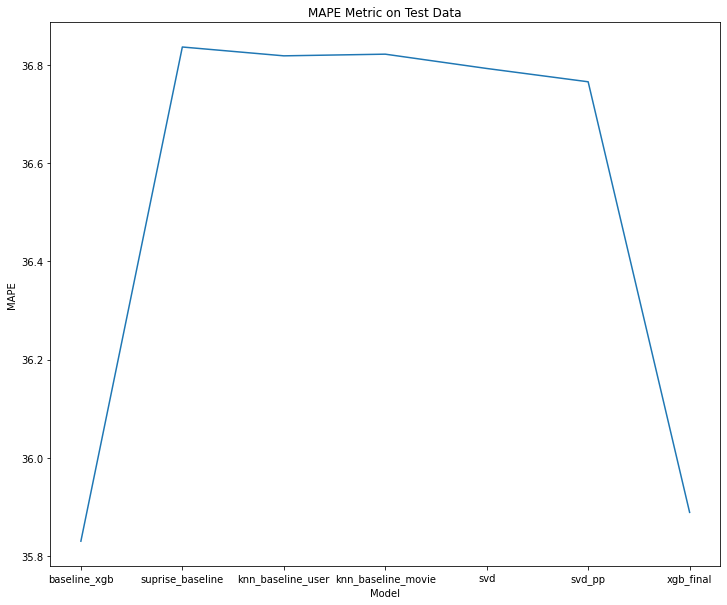

In [61]:
plotFinalMetrics(modelNames, mapeValues, "MAPE Metric on Test Data", Constant.mape.upper())

### Save the results in CSV format

In [63]:
if not os.path.exists(modelResultPath):
  pd.DataFrame(modelEvalTest).to_csv(modelResultPath)

In [64]:
 pd.DataFrame(modelEvalTest).loc['rmse'].sort_values()

baseline_xgb           1.1006
xgb_final             1.10178
svd                   1.11449
svd_pp                1.11496
knn_baseline_user     1.11498
knn_baseline_movie    1.11511
suprise_baseline      1.11545
Name: rmse, dtype: object